# Are statin prescribing ratios different for dispensing practices?

#### 1. Obtain GP Prescribing data
#### 2. Cut GP Prescribing data for things of interest (e.g statins)
#### 3. Obtain list of dispensing practices
#### 3a. Add codes to list of dispensing practices (name and address only is provided)
#### 4. Combine things of interest cut and dispensing practice list
#### 5. Compare dispensing vs non-dispensing prescribing ratios for things of interest

In [1]:
import requests
from StringIO import StringIO
from numpy import nan as NA
import pandas as pd
import zipfile
import re
%matplotlib inline
import matplotlib.pyplot as plt
import xlrd
import statsmodels.api as sm
from patsy import dmatrices, dmatrix
import scipy as scipy
import numpy as np

In [2]:
def fetch_prescribing_data():
    url = 'http://datagov.ic.nhs.uk/presentation/2015_01_January/T201501PDPI+BNFT.CSV' #gp prescribing data (Jan 2015)
    r = requests.get(url)
    data = r.content
    df = (pd.read_csv(StringIO(data)))
    df.to_csv('datas/T201501PDPI+BNFT.CSV')

def fetch_dispensary_data():
    url = 'http://systems.hscic.gov.uk/data/ods/datadownloads/data-files/edispensary.zip'
    r = requests.get(url)
    z = zipfile.ZipFile(StringIO(r.content))
    df = pd.read_csv(z.open('edispensary.csv'))
    df.to_csv('datas/edispensary.csv')

def fetch_gp_details():
    url = 'http://systems.hscic.gov.uk/data/ods/datadownloads/data-files/epraccur.zip'
    r = requests.get(url)
    z = zipfile.ZipFile(StringIO(r.content))
    df = pd.read_csv(z.open('epraccur.csv'))
    df.to_csv('datas/epraccur.csv')

def clean_prescribing_data(df):
    df.columns = [x.strip() for x in df.columns] #gets rid of variable whitespace
    return(df)

def cut_prescribing_data(df, cut_pattern, junk):
    df = df[df['BNF NAME'].str.contains(cut_pattern)] #cut for rows with target in them
    df = df[~df['BNF NAME'].str.contains(junk)] #throw away unwanted drugs
    #df.to_csv('datas/%sJan2015.csv' % target) #save the result
    return(df)

def drugs_analysis(df):
    print 'Unique drugs in the analysis: '
    print df['BNF NAME'].unique() 
    print '\n'
    print 'Number of practices prescribing each drug in the analysis: '
    print df['BNF NAME'].value_counts()
    print '\n'

    
def clean_dispensing_practice_addresses(dpad):
    dpad = dpad['Dispensing Practices Address Details'].dropna()
    dpad = dpad.reset_index()
    del dpad['index']
    dpad['Dispensing Practices Address Details'] = dpad['Dispensing Practices Address Details'].str.strip()
    dpad['Dispensing Practices Address Details'] = dpad['Dispensing Practices Address Details'].str.replace('\n', ' ')
    dpad['NAME'] = dpad['Dispensing Practices Address Details'].str.split(',').str[0].str.upper()
    dpad['POSTCODE'] = dpad['Dispensing Practices Address Details'].str.split(',').str[-1].astype(str).str.strip()
    dpad.ix[254,2] = 'BN25 1HH' #one practice lacked a postcode.... we fix this manually
    dpad.ix[254,1] = 'Old School Surgery'
    return(dpad)

def validate_dispensing_postcodes():
    assert(len(dpad[~dpad.Postcode.str.contains(r'[A-Z]{1,2}[0-9R][0-9A-Z]? [0-9][A-Z]{2}')]) == 0) #length of dataframe of postcodes that don't pass regex should be 0 

def add_dispensing_practice_column(df):
    df['DP'] = df.PRACTICE.isin(dpad.PRACTICE) #add column DP to identify Dispensing Practices
    return(df)

def add_proportion_bad(df, bad):
    df['is_bad'] = df['BNF NAME'].str.contains(bad) #add column for Is Bad
    df = df.groupby(['DP','PRACTICE', 'is_bad']).ITEMS.sum()
    df = df.unstack()
    df = df.reset_index()
    df = df.fillna(0.0) #applying groupby when there are no items in a category generates NaNs where we would instead prefer 0's
    df.columns = ['DP', 'PRACTICE', 'good', 'bad']
    df['Proportion'] = (df['bad'] / (df['bad'] + df['good']))
    return(df)

def add_gp_details(df):
    df = pd.merge(df, gpdetail, on='PRACTICE')
    return(df)


def prescribing_setting_analysis(df):
    lookup =  {0:'Other' , 1:'WIC Practice' , 2:'OOH Practice' , 3:'WIC + OOH Practice' , 4:'GP Practice' , 
               8:'Public Health Service' , 9:'Community Health Service' , 10:'Hospital Service' , 11:'Optometry Service' , 
              12:'Urgent & Emergency Care' , 13:'Hospice' , 14:'Care Home / Nursing Home' , 15:'Border Force' , 
              16:'Young Offender Institution' , 17:'Secure Training Centre' , 18:'Secure Children\'s Home' , 19:'Immigration Removal Centre' , 
              20:'Court' , 21:'Police Custody' , 22:'Sexual Assault Referral Centre\'(SARC)' , 24:'Other – Justice Estate' , 
              25:'Prison'}  
   
    df['Prescribing Setting'] = df['Prescribing Setting'].map(lambda x: lookup.get(x))
    
    print 'Unique prescribing settings: '
    print df['Prescribing Setting'].unique() 
    print '\n'

    
    print 'Number of each practices in each type of prescribing setting: '
    print df['Prescribing Setting'].value_counts()
    print '\n'

    
    print 'Mean badness proportion by prescribing setting: '
    prop_mean = df.groupby('Prescribing Setting').Proportion.mean()
    prop_mean.sort(ascending=False)
    print prop_mean
    

def throw_away_not_gp_practices(df):
    df = df[df['Prescribing Setting'] == 'GP Practice'] #throw away ones that aren't GP practices
    return(df)

def mwwranksum_and_z_stat(df):
    from scipy import stats

    z_stat, p_val = stats.ranksums(df[df.DP == True]['Proportion'], df[df.DP == False]['Proportion'])

    print "MWW RankSum P for treatments 1 and 2 =", p_val
    print "Z statistic for treatments 1 and 2 =", z_stat
    
def model(df):
           
    y, X = dmatrices('Proportion ~ C(DP) + C(CCG)', data=df, return_type='dataframe') 

    mod = sm.Poisson(y, X) #http://statsmodels.sourceforge.net/devel/endog_exog.html
    
    res = mod.fit(maxiter=100)
    
    print res.summary()

    return res

def proportion_analysis(df, target):
    df.columns = ['DP', 'PRACTICE', 'not_%s' % target[:8], target[:8], 'Proportion', 'NAME', 'POSTCODE', 
                  'Prescribing Setting', 'CCG']
    
    print '\n non-dispensing practices \n'
    df[df['DP'] == False].hist(bins=40)
    print df[df['DP'] == False].describe()
    print ('\nmean proportion is: %.3f \nmedian proportion is: %.3f \nvariance is: %.3f \nskew is: %3.f\n' % 
            (df[df['DP'] == False]['Proportion'].mean(),  df[df['DP'] == False]['Proportion'].median(),  
             df[df['DP'] == False]['Proportion'].var(),  
             df[df['DP'] == False]['Proportion'].skew()))
    
    print '\n dispensing practices: \n'
    df[df['DP'] == True].hist(bins=28)
    print df[df['DP'] == True].describe()
    print ('\nmean proportion is: %.3f \nmedian proportion is: %.3f \nvariance is: %.3f \nskew is: %3.f\n' % 
            (df[df['DP'] == True]['Proportion'].mean(),  df[df['DP'] == True]['Proportion'].median(),  
             df[df['DP'] == True]['Proportion'].var(),  
             df[df['DP'] == True]['Proportion'].skew()))
    
    
    df[['DP', 'Proportion']].boxplot(by='DP', figsize=(6,6))
    plt.title("Prescribing in non-dispensing vs dispensing practices")
    plt.suptitle("")
    plt.ylabel('Proportion of group items that are %s' % target[:8])
    plt.xlabel('Dispensing practice')
    
    mwwranksum_and_z_stat(df)
        
    model(df)
    
    
def prep_data_for_stata(df):
    
    ccg_codes = df.CCG.unique()
    ccg_lookup = zip(list(ccg_codes), range(0,209))
    ccg_lookup = dict(ccg_lookup)
    
    df = df[['DP', 'Proportion', 'CCG']]
    df['DP'] = df['DP'].astype(str).str.replace('False','0').str.replace('True','1')
    df['CCG'] = df['CCG'].map(lambda x: ccg_lookup.get(x))
    df['DP'] = df['DP'].astype(int)
    df['CCG'] = df['CCG'].astype(int)
    
    df.to_csv('pa_research_for_stata.csv')
    
    
def pa_research(df, cut_pattern, junk, target):
    df = cut_prescribing_data(df, cut_pattern, junk)
    drugs_analysis(df)
    df = add_dispensing_practice_column(df)
    df = add_proportion_bad(df, target)
    df = add_gp_details(df)
    prescribing_setting_analysis(df)
    df = throw_away_not_gp_practices(df)
    proportion_analysis(df, target)

#nb df = pd.read_csv('http://datagov.ic.nhs.uk/presentation/2015_01_January/T201501PDPI+BNFT.CSV') should also work but seems slower

In [3]:
gpdetail = pd.read_csv('datas/epraccur.csv') #from http://systems.hscic.gov.uk/data/ods/datadownloads/data-files/epraccur.zip

dpad_formatting_junk = ['Dispensing Practices Address Details', 'Primary Care Trust:', 'Report For:', 'Practice Name and Address', 'January 2015']
dpad = pd.read_excel('datas/Disp Pracs Name and Address 2015-01-31.xls', usecols=[0], na_values=dpad_formatting_junk) #load dispensing practice list

dpad = clean_dispensing_practice_addresses(dpad)

gpdetail = gpdetail.icol([1,2,10,26,15]) #throw away columns we don't care about
gpdetail.columns = ['PRACTICE', 'NAME', 'POSTCODE', 'Prescribing Setting', 'CCG']

dpad = pd.merge(gpdetail, dpad, on=['NAME','POSTCODE']) #merge to add practice codes

df = pd.read_csv('datas/T201501PDPI+BNFT.CSV') #commented because need only run once and is slow
df = clean_prescribing_data(df) #commented because need only run once and is slow



In [4]:
def statin_analysis(df):
    print '\n---Statin analysis---\n'
    cut_pattern = 'statin|Rosuvastatin|Lipitor|Lescol|Lipostat|Crestor|Zocor'
    junk = 'Nystatin|Sandostatin|Ecostatin'
    target = 'Rosuvastatin|Lipitor|Lescol|Lipostat|Crestor|Zocor'
    
    pa_research(df, cut_pattern, junk, target)

In [5]:
def ppi_analysis(df):
    print '\n---PPI analysis---\n'
    cut_pattern = 'prazole|Esomeprazole|Rabeprazole|Nexium|Losec|Zoton|Protium|Pariet'
    junk = 'Aripiprazole'
    target = 'Esomeprazole|Rabeprazole|Nexium|Losec|Zoton|Protium|Pariet'
    
    pa_research(df, cut_pattern, junk, target)

In [6]:
def ace_analysis(df):
    print '\n---ACE-i analysis---\n'
    cut_pattern = 'pril|Captopril|Capoten|Noyada|Innovace|Fosinopril|Tanatril|Imidapril|Zestril|Perdix|Moexipril|Coversyl|Quinapril|Quinil|Accupro|Tritace|Trandolapril|Cilazapril'
    junk = 'Caprilon|Sprilon'
    target = 'Captopril|Capoten|Noyada|Innovace|Fosinopril|Tanatril|Imidapril|Zestril|Perdix|Moexipril|Coversyl|Quinapril|Quinil|Accupro|Tritace|Trandolapril|Cilazapril'
    
    pa_research(df, cut_pattern, junk, target)

In [7]:
def arb_analysis(df):
    print '\n---ARB-II analysis---\n'
    cut_pattern = 'sartan|Azilsartan|Edarbi|Amias|Eprosartan|Teveten|Aprovel|Cozaar|Olmesartan|Olmetec|Micardis|Telmisartan|Valsartan|Diovan'
    junk = 'no_junk_found'
    target = 'Azilsartan|Edarbi|Amias|Eprosartan|Teveten|Aprovel|Cozaar|Olmesartan|Olmetec|Micardis|Telmisartan|Valsartan|Diovan'
    
    pa_research(df, cut_pattern, junk, target)

In [8]:
def main():
    statin_analysis(df)
    ppi_analysis(df)
    ace_analysis(df)
    arb_analysis(df)

In [9]:
# need to fix add_proportion using this: http://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
# note limitation currently is that have not made combined preparations a target or excluded as junk... they will currently still be included 

In [10]:
df[df['BNF NAME'].str.contains('Simvastatin_Tab 20mg|Rosuvastatin Calc_Tab 10mg')][:10]

,SHA,PCT,PRACTICE,BNF CODE,BNF NAME,ITEMS,NIC,ACT COST,QUANTITY,PERIOD,
99,Q44,RXA,Y00327,0212000Y0AAABAB,Simvastatin_Tab 20mg,1,0.14,0.24,4,201501,
1056,Q44,RY7,N85645,0212000Y0AAABAB,Simvastatin_Tab 20mg,1,0.11,0.21,3,201501,
2050,Q44,01C,N81002,0212000AAAAAAAA,Rosuvastatin Calc_Tab 10mg,14,360.60,332.98,560,201501,
2074,Q44,01C,N81002,0212000Y0AAABAB,Simvastatin_Tab 20mg,164,242.88,227.20,6734,201501,
3662,Q44,01C,N81013,0212000AAAAAAAA,Rosuvastatin Calc_Tab 10mg,14,252.42,233.15,392,201501,
3682,Q44,01C,N81013,0212000Y0AAABAB,Simvastatin_Tab 20mg,107,123.51,115.41,3424,201501,
5155,Q44,01C,N81021,0212000AAAAAAAA,Rosuvastatin Calc_Tab 10mg,8,252.42,233.08,392,201501,
5176,Q44,01C,N81021,0212000Y0AAABAB,Simvastatin_Tab 20mg,152,189.17,180.28,5247,201501,
6603,Q44,01C,N81022,0212000AAAAAAAA,Rosuvastatin Calc_Tab 10mg,12,252.42,233.12,392,201501,
6624,Q44,01C,N81022,0212000Y0AAABAB,Simvastatin_Tab 20mg,182,184.55,174.27,5117,201501,



---Statin analysis---

Unique drugs in the analysis: 
['Simvastatin_Tab 20mg                    '
 'Simvastatin_Tab 40mg                    '
 'Atorvastatin_Tab 40mg                   '
 'Rosuvastatin Calc_Tab 10mg              '
 'Rosuvastatin Calc_Tab 20mg              '
 'Rosuvastatin Calc_Tab 5mg               '
 'Simvastatin/Ezetimibe_Tab 80mg/10mg     '
 'Atorvastatin_Tab 10mg                   '
 'Atorvastatin_Tab 20mg                   '
 'Atorvastatin_Tab 80mg                   '
 'Lipitor_Tab 20mg                        '
 'Fluvastatin Sod_Cap 40mg                '
 'Fluvastatin Sod_Tab 80mg M/R            '
 'Pravastatin Sod_Tab 10mg                '
 'Pravastatin Sod_Tab 20mg                '
 'Pravastatin Sod_Tab 40mg                '
 'Simvastatin_Tab 10mg                    '
 'Simvastatin_Tab 80mg                    '
 'Zocor_Tab 40mg                          '
 'Rosuvastatin Calc_Tab 40mg              '
 'Crestor_Tab 10mg                        '
 'Lipitor_Tab 10mg   

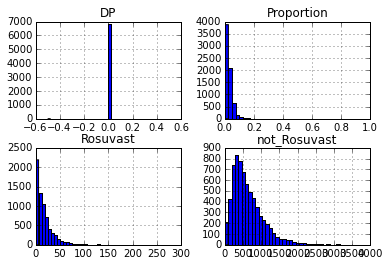

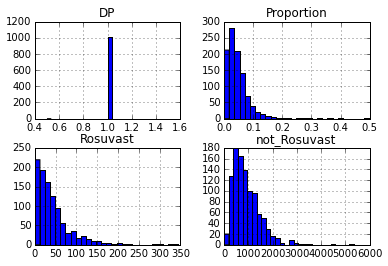

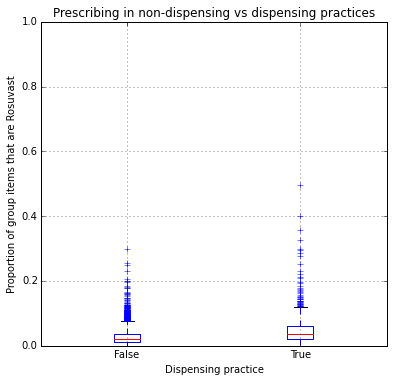

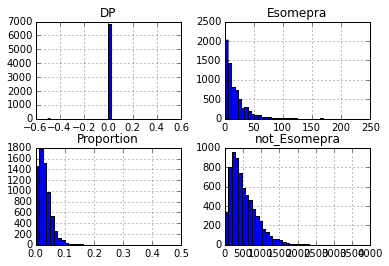

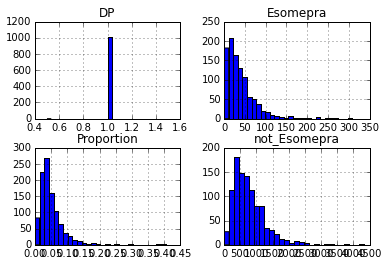

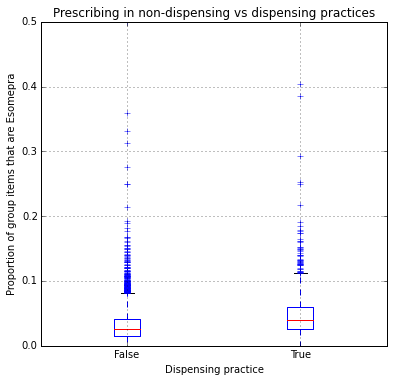

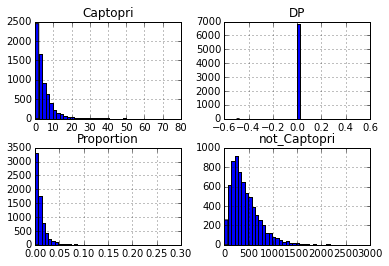

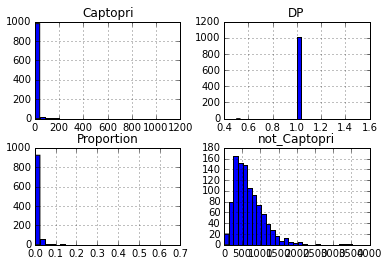

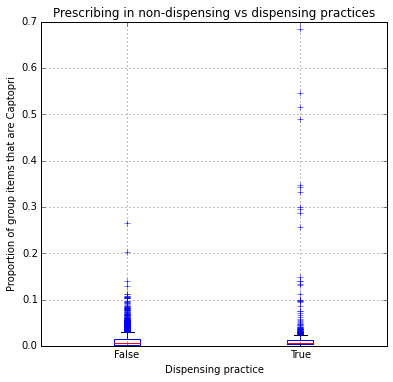

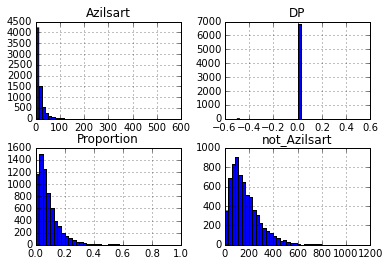

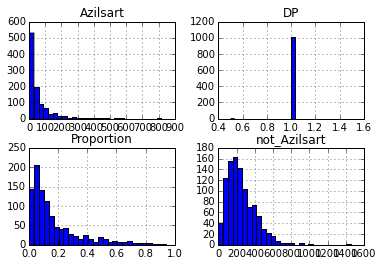

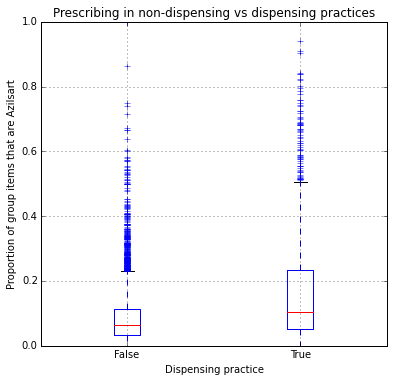

In [11]:
main()